In [1]:
%load_ext google.cloud.bigquery 
from google.cloud import bigquery

## Using BigQuery ML to Predict Penguin Weight

### Overview
In this notebook, we will use the [penguin table](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins&page=table&_ga=2.220042073.1354982557.1633082321-1341342707.1620127293) to create a model that predicts the weight of a penguin based on the penguin's species, island of residence, culmen length and depth, flipper length, and sex.

This notebook introduces data analysts to BigQuery ML. BigQuery ML enables users to create and execute machine learning models in BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.


### Learning objectives
- Create a linear regression model using the `CREATE MODEL` statement with BigQuery ML.
- Evaluate the ML model with the `ML.EVALUATE` function.
- Make predictions using the ML model with the `ML.PREDICT` function.

### Enable the BigQuery API
1. In the Cloud Console, on the Navigation menu (View the navigation menu icon), click APIs & services > Library.

2. Search for BigQuery API, and then click Enable if it isn't already enabled.

### Task 1. Create your dataset

First up, in case you are not aware, it is possible to access Biq Query datasets and perform SQL queries on them without even leaving a Jupyter Notebook running in a local environment! The magic word is..... `%%bigquery` :

Hopefully it works for you - took me a bit of digging around but what worked for me was to include this on the very first line of this NoteBook :

    %load_ext google.cloud.bigquery

In [2]:
%%bigquery
# SQL query to get a fields from dataset which prints the 10 records
SELECT *
FROM `bigquery-public-data.ml_datasets.penguins`
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE
2,Adelie Penguin (Pygoscelis adeliae),Dream,40.9,18.9,184.0,3900.0,MALE
3,Chinstrap penguin (Pygoscelis antarctica),Dream,46.5,17.9,192.0,3500.0,FEMALE
4,Adelie Penguin (Pygoscelis adeliae),Dream,37.3,16.8,192.0,3000.0,FEMALE
5,Adelie Penguin (Pygoscelis adeliae),Dream,43.2,18.5,192.0,4100.0,MALE
6,Chinstrap penguin (Pygoscelis antarctica),Dream,46.9,16.6,192.0,2700.0,FEMALE
7,Chinstrap penguin (Pygoscelis antarctica),Dream,50.5,18.4,200.0,3400.0,FEMALE
8,Chinstrap penguin (Pygoscelis antarctica),Dream,49.5,19.0,200.0,3800.0,MALE
9,Adelie Penguin (Pygoscelis adeliae),Dream,40.2,20.1,200.0,3975.0,MALE


The first step is to create a BigQuery dataset to store your ML model. To create your dataset:

1. In the Cloud Console, on the Navigation menu, click BigQuery.

2. In the Explorer panel, click the View actions icon (three vertical dots) next to your project ID, and then click Create dataset.

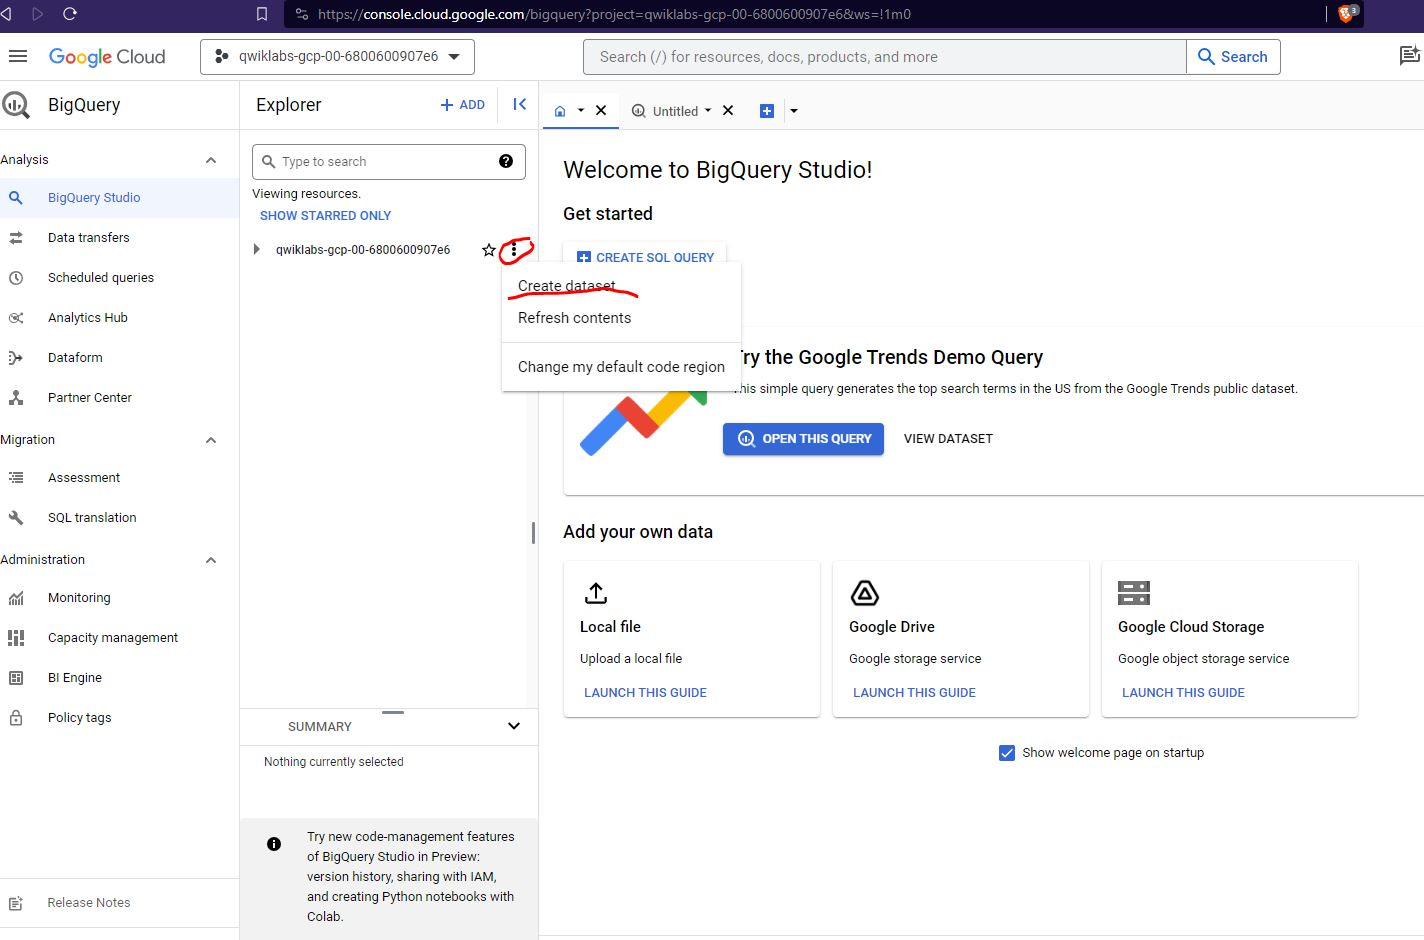

3. On the Create dataset page:

- For Dataset ID, type `bqml_tutorial`

- (Optional) For Data location, select us (multiple regions in United States). Currently, the public datasets are stored in the US multi-region location. For simplicity, you should place your dataset in the same location.

4. Leave the remaining settings as their defaults, and click Create Dataset.

### Task 2. Create your model
Next, you create a linear regression model using the penguins table for BigQuery.

The following standard SQL query is used to create the model you use to predict the weight of a penguin:

In [ ]:
#standardSQL
CREATE OR REPLACE MODEL `bqml_tutorial.penguins_model`
OPTIONS
  (model_type='linear_reg',
  input_label_cols=['body_mass_g']) AS
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.penguins`
WHERE
  body_mass_g IS NOT NULL

### Query details

The [CREATE MODEL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) clause is used to create and train the model named bqml_tutorial.penguins_model.

The OPTIONS(model_type='linear_reg', input_label_cols=['body_mass_g']) clause indicates that you are creating a linear regression model. A [linear regression](https://en.wikipedia.org/wiki/Linear_regression) is a type of regression model that generates a continuous value from a linear combination of input features. The body_mass_g column is the input label column. For linear regression models, the label column must be real-valued (the column values must be real numbers).

This query's SELECT statement uses all the columns in the bigquery-public-data.ml_datasets.penguins table. This table contains the following columns that will all be used to predict a penguin's weight:

- species: Species of penguin (STRING)
- island: Island that the penguin lives on (STRING)
- culmen_length_mm: Length of culmen in millimeters (FLOAT64)
- culmen_depth_mm: Depth of culmen in millimeters (FLOAT64)
- flipper_length_mm: Length of the flipper in millimeters (FLOAT64)
- sex: The sex of the penguin (STRING)

The FROM clause — bigquery-public-data.ml_datasets.penguins — indicates that you are querying the penguins table in the ml_datasets dataset. This dataset is in the bigquery-public-data project.

The WHERE clause — WHERE body_mass_g IS NOT NULL — excludes rows where body_mass_g is NULL.

To run the CREATE MODEL query to create and train your model:

1. In the Cloud Console, click Compose new query.

2. In the Query editor text area, enter the previous standard SQL query

3. Click run.

In addition to creating the model, running the CREATE MODEL command trains the model you create.

The query takes about 30 seconds to complete, after which your model (penguins_model) appears in the navigation panel. Because the query uses a CREATE MODEL statement to create a table, you do not see query results.

> Note: You can ignore the warning about NULL values for input data

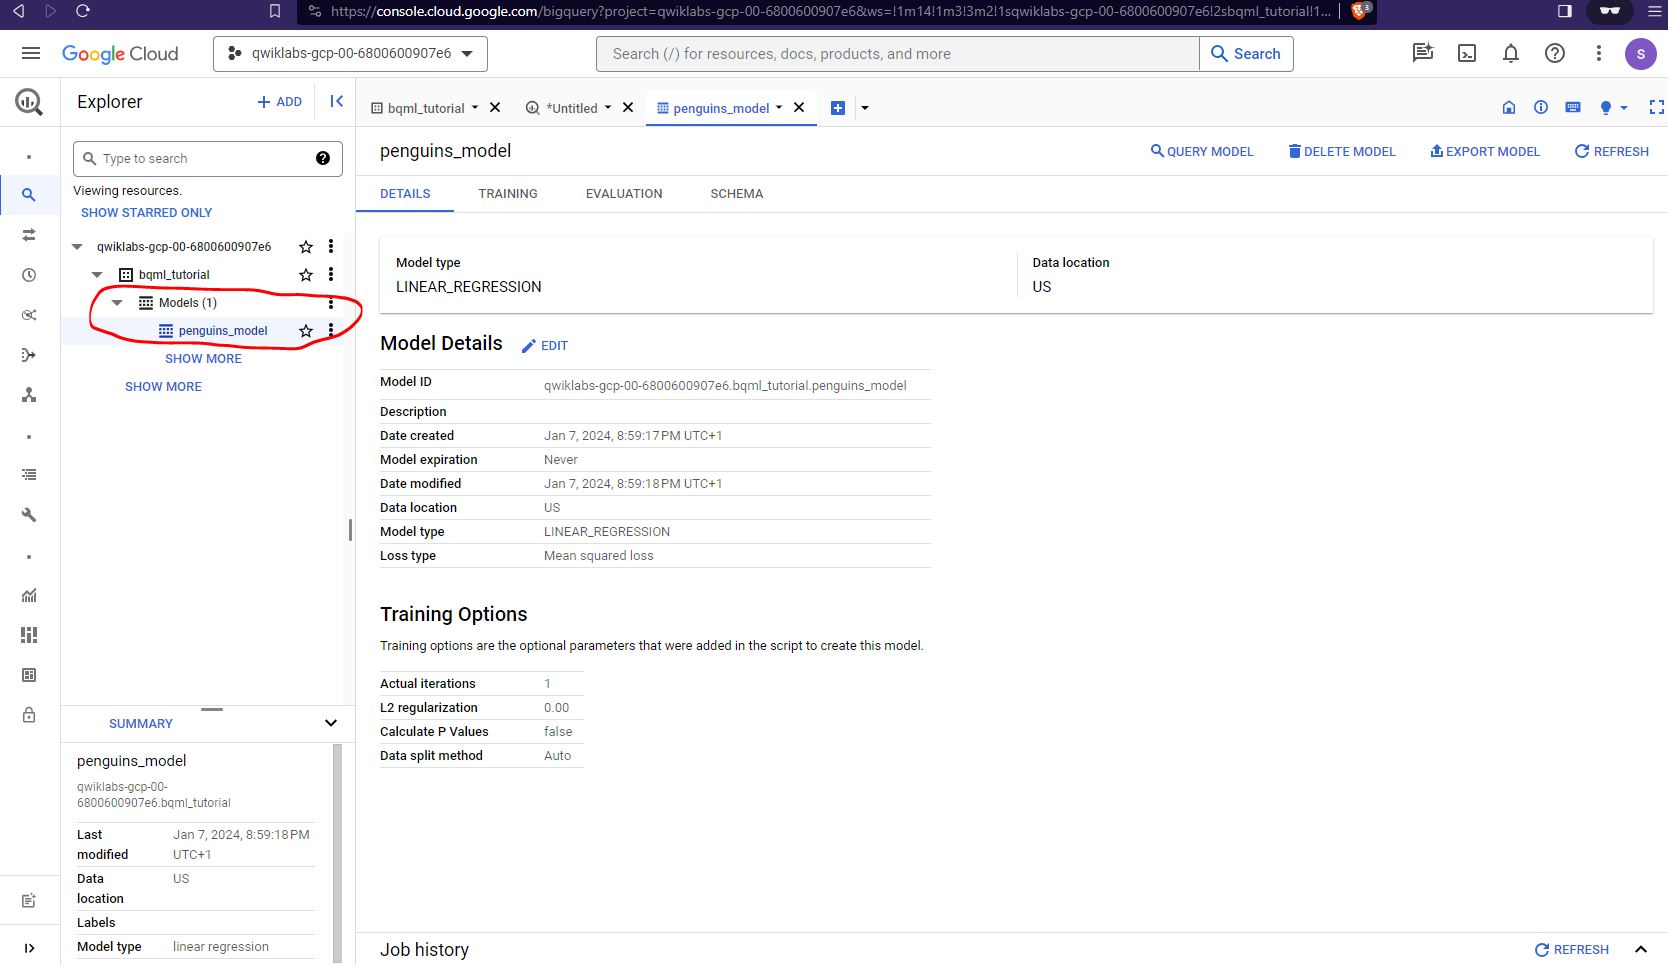

### Task 3. Get training statistics 

To see the results of the model training, you can use the [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) function, or you can view the statistics in the Cloud Console. In this tutorial, you use the Cloud Console.

A machine learning algorithm builds a model by examining many examples and attempting to find a model that minimizes loss. This process is called empirical risk minimization.

Loss is the penalty for a bad prediction: a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater. The goal of training a model is to find a set of weights and biases that have low loss, on average, across all examples.

1. In the Cloud Console navigation panel, in the Explorer section, expand [PROJECT_ID] > bqml_tutorial > Models (1), and then click penguins_model.

2. Click the Training tab, and then click Table. The results should look like the following:

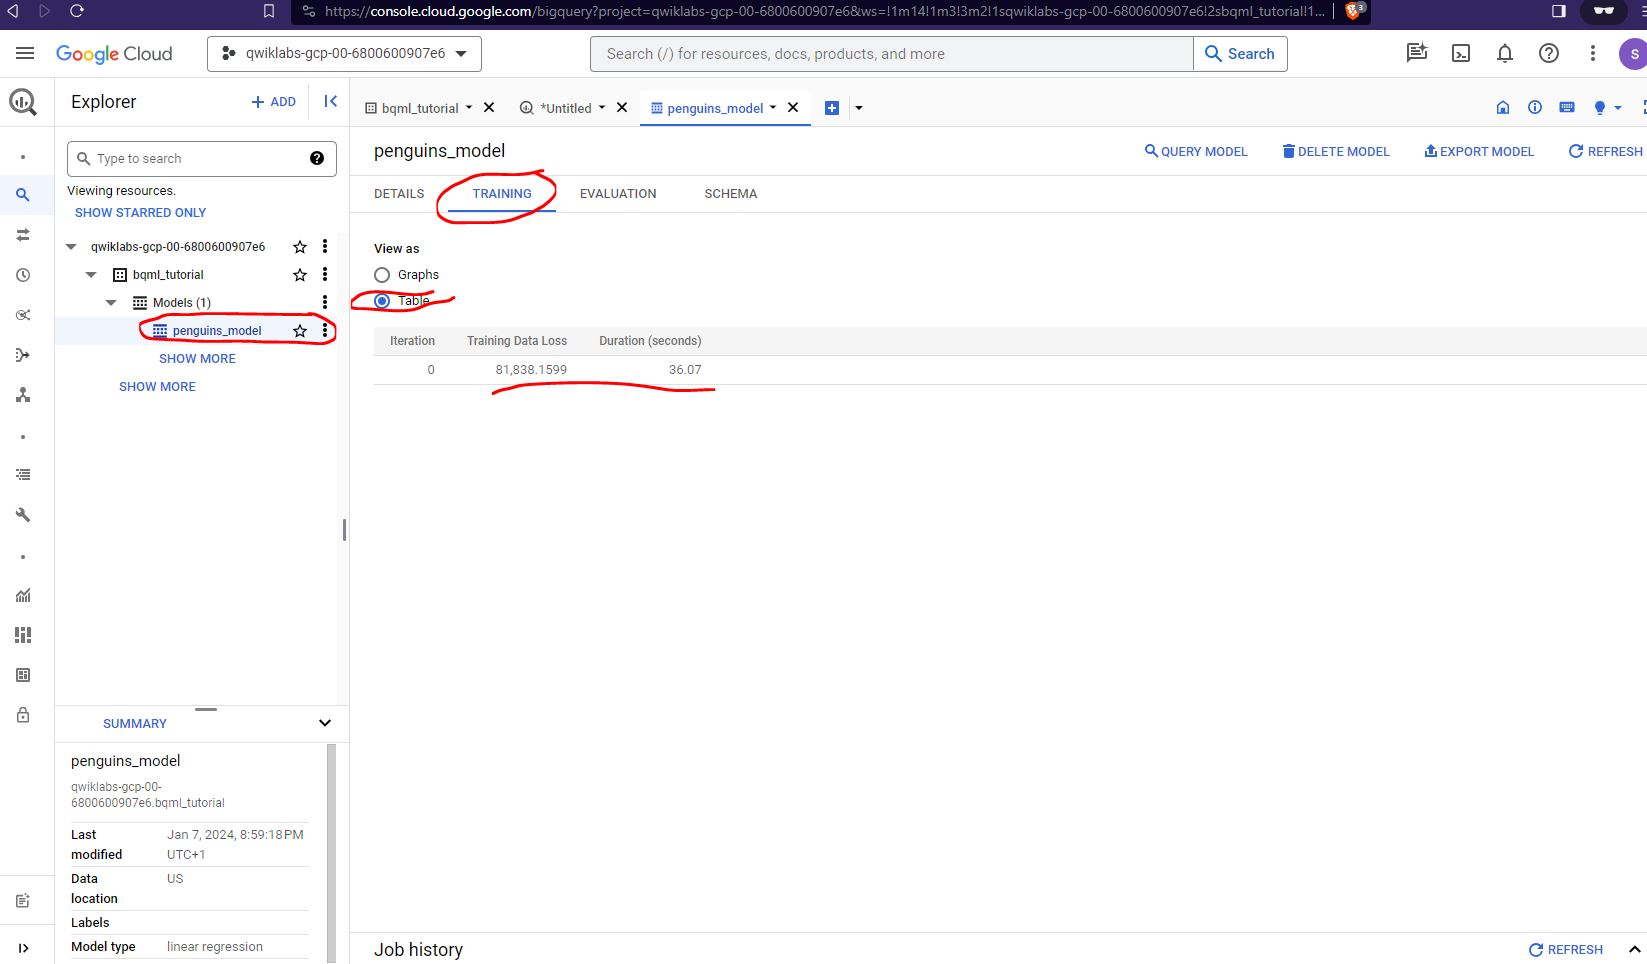

The Training Data Loss column represents the loss metric calculated after the model is trained on the training dataset. Because you performed a linear regression, this column is the [mean squared error](https://developers.google.com/machine-learning/glossary/#MSE).

A [normal_equation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm#optimize_strategy) optimization strategy is automatically used for this training, so only one iteration is required to converge to the final model. For more details on the optimize_strategy option, see the [CREATE MODEL statement for generalized linear models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm).

For more details on the ML.TRAINING_INFO function and "optimize_strategy" training option, see the [BigQuery ML syntax reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train).

### Task 4. Evaluate your model

After creating your model, you evaluate the performance of the model using the ML.EVALUATE function. The ML.EVALUATE function evaluates the predicted values against the actual data.

The following query is used to evaluate the model:

In [ ]:
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.penguins_model`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.ml_datasets.penguins`
    WHERE
      body_mass_g IS NOT NULL))

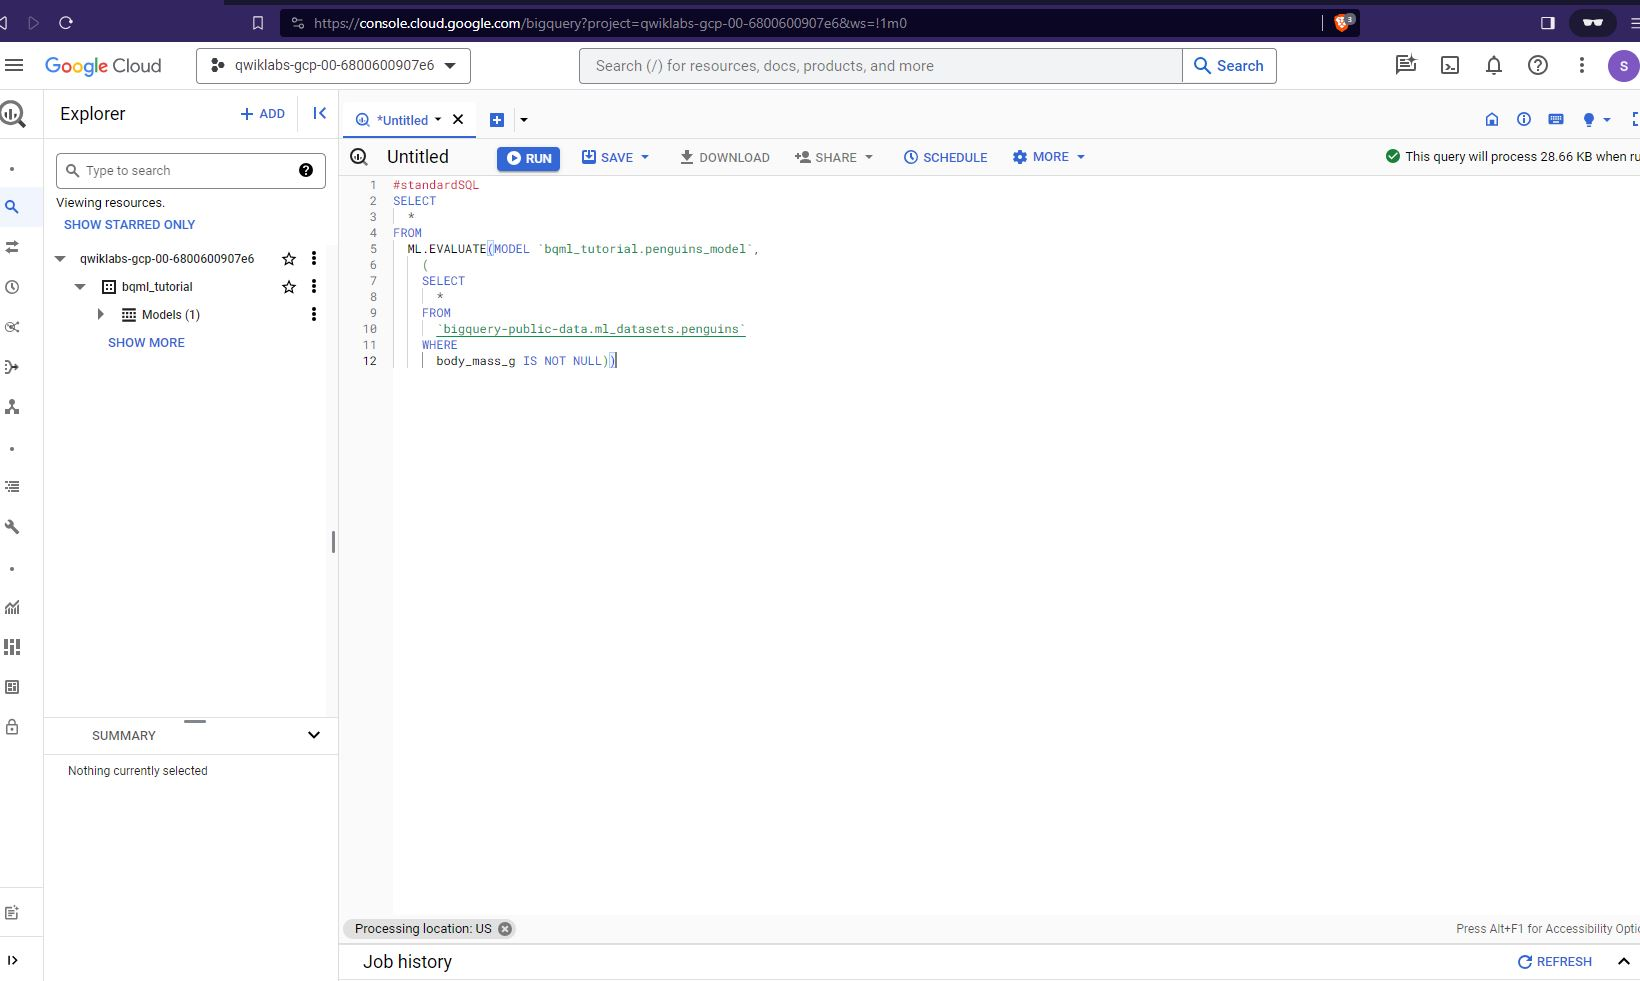

### Query details
- The first SELECT statement retrieves the columns from your model.
- The FROM clause uses the [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) function against your model: bqml_tutorial.penguins_model.
- This query's nested SELECT statement and FROM clause are the same as those in the CREATE MODEL query.
- The WHERE clause — WHERE body_mass_g IS NOT NULL — excludes rows where body_mass_g is NULL.

A proper evaluation would be on a subset of the penguins table that is separate from the data used to train the model. You can also call ML.EVALUATE without providing the input data. ML.EVALUATE will retrieve the evaluation metrics calculated during training, which uses the automatically reserved evalution dataset:

In [ ]:
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.penguins_model`)

You can also use the Cloud Console to view the evaluation metrics calculated during the training. The results should look like the following:

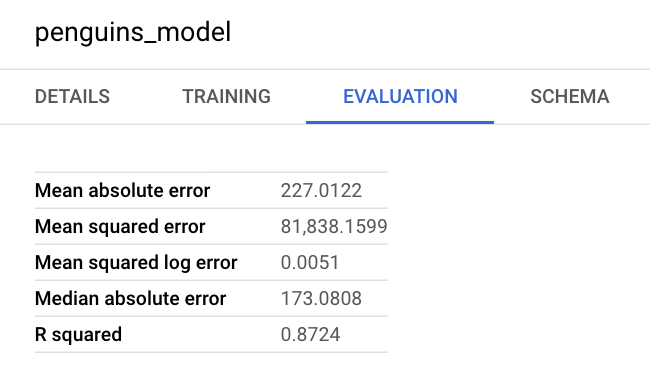

### Run the ML.EVALUATE query
To run the `ML.EVALUATE` query that evaluates the model:

1. In the Cloud Console, click Compose new query.

2. In the Query editor text area, enter the previous standard SQL query.

3. (Optional) To set the data location, click More > Query settings. For Data location, select us (multiple regions in United States).

4. Click Run.

5. When the query is complete, click the Results tab below the query text area. The results should look like the following:

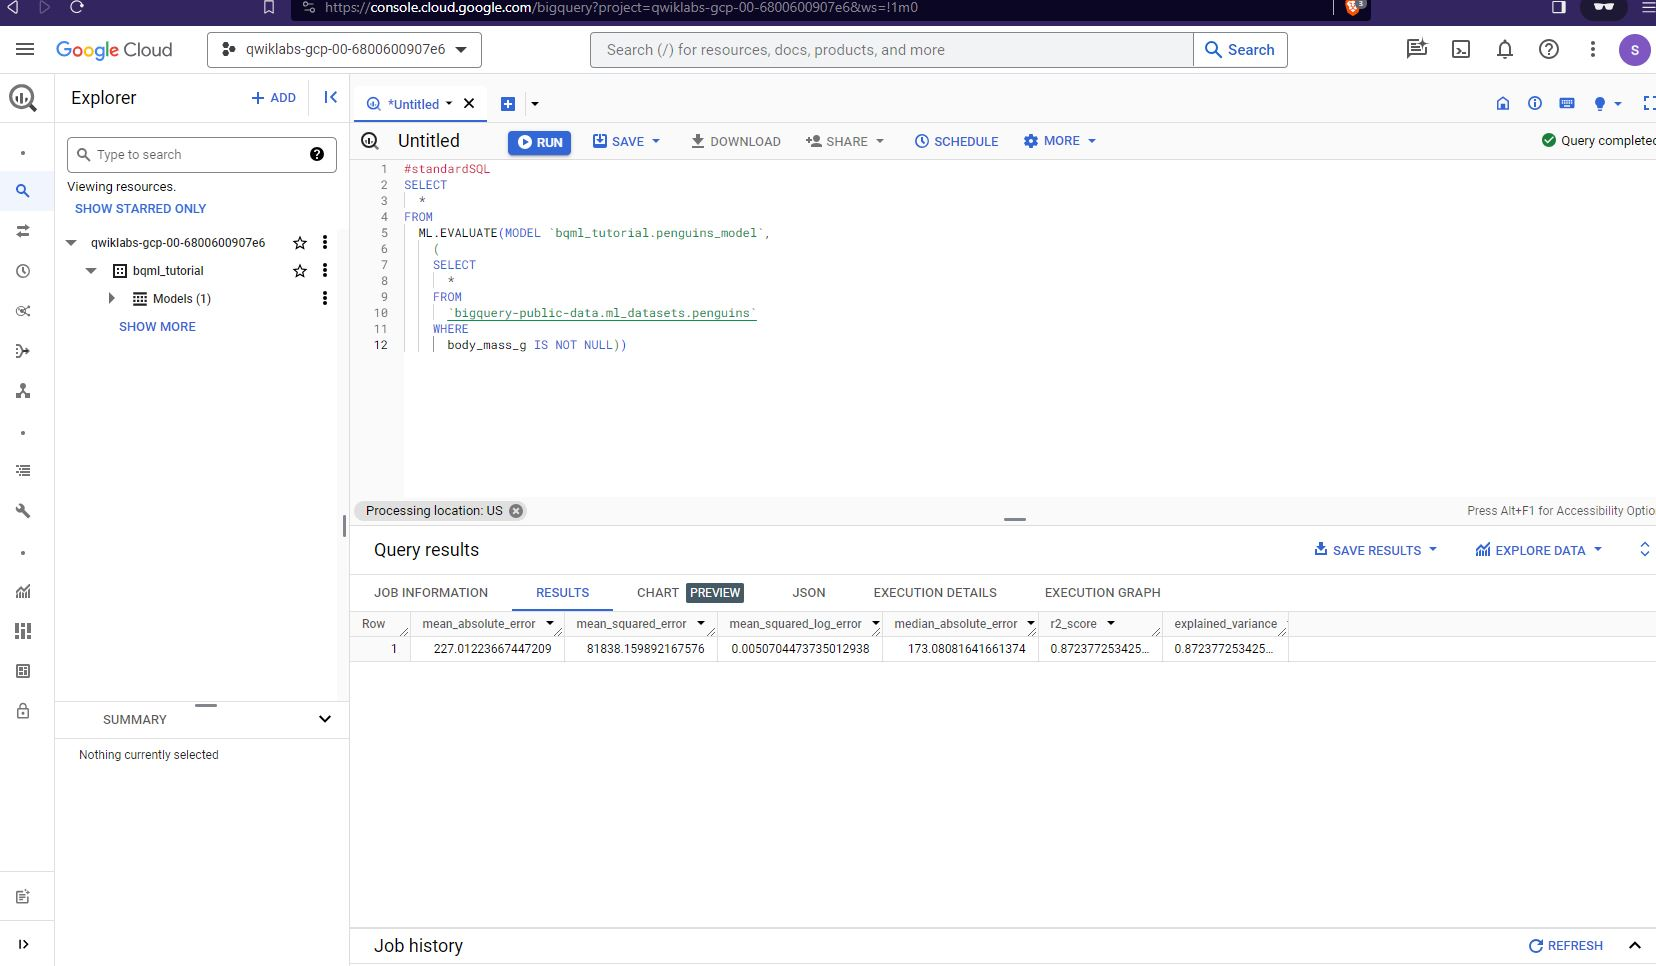

Because you performed a linear regression, the results include the following columns:

- mean_absolute_error
- mean_squared_error
- mean_squared_log_error
- median_absolute_error
- r2_score
- explained_variance

An important metric in the evaluation results is the [$R^2$ score](https://en.wikipedia.org/wiki/Coefficient_of_determination). The $R^2$ score is a statistical measure that determines whether the linear regression predictions approximate the actual data. 0 indicates that the model explains none of the variability of the response data around the mean. 1 indicates that the model explains all the variability of the response data around the mean.


### Task 5. Use your model to predict outcomes

Now that you have evaluated your model, the next step is to use it to predict an outcome. You use your model to predict the body mass in grams of all penguins that reside in Biscoe.

The following query is used to predict the outcome:

In [ ]:
#standardSQL
SELECT
  *
FROM
  ML.PREDICT(MODEL `bqml_tutorial.penguins_model`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.ml_datasets.penguins`
    WHERE
      body_mass_g IS NOT NULL
      AND island = "Biscoe"))

### Query details

The first SELECT statement retrieves the predicted_body_mass_g column along with the columns in bigquery-public-data.ml_datasets.penguins. This column is generated by the ML.PREDICT function. When you use the ML.PREDICT function, the output column name for the model is predicted_<label_column_name>. For linear regression models, predicted_label is the estimated value of label. For logistic regression models, predicted_label is one of the two input labels depending on which label has the higher predicted probability.

- The [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) function is used to predict results using your model: bqml_tutorial.penguins_model.
- This query's nested SELECT statement and FROM clause are the same as those in the CREATE MODEL query.
- The WHERE clause — WHERE island = "Biscoe" — indicates that you are limiting the prediction to the island of Biscoe.


### Run the ML.PREDICT query
To run the query that uses the model to predict an outcome:

1. In the Cloud Console, click Compose new query.

2. In the Query editor text area, enter the previous standard SQL query.

3. (Optional) To set the data location, click More > Query settings. For Data location, select us (multiple regions in United States).

4. Click Run.

5. When the query is complete, click the Results tab below the query text area. The results should look like the following:

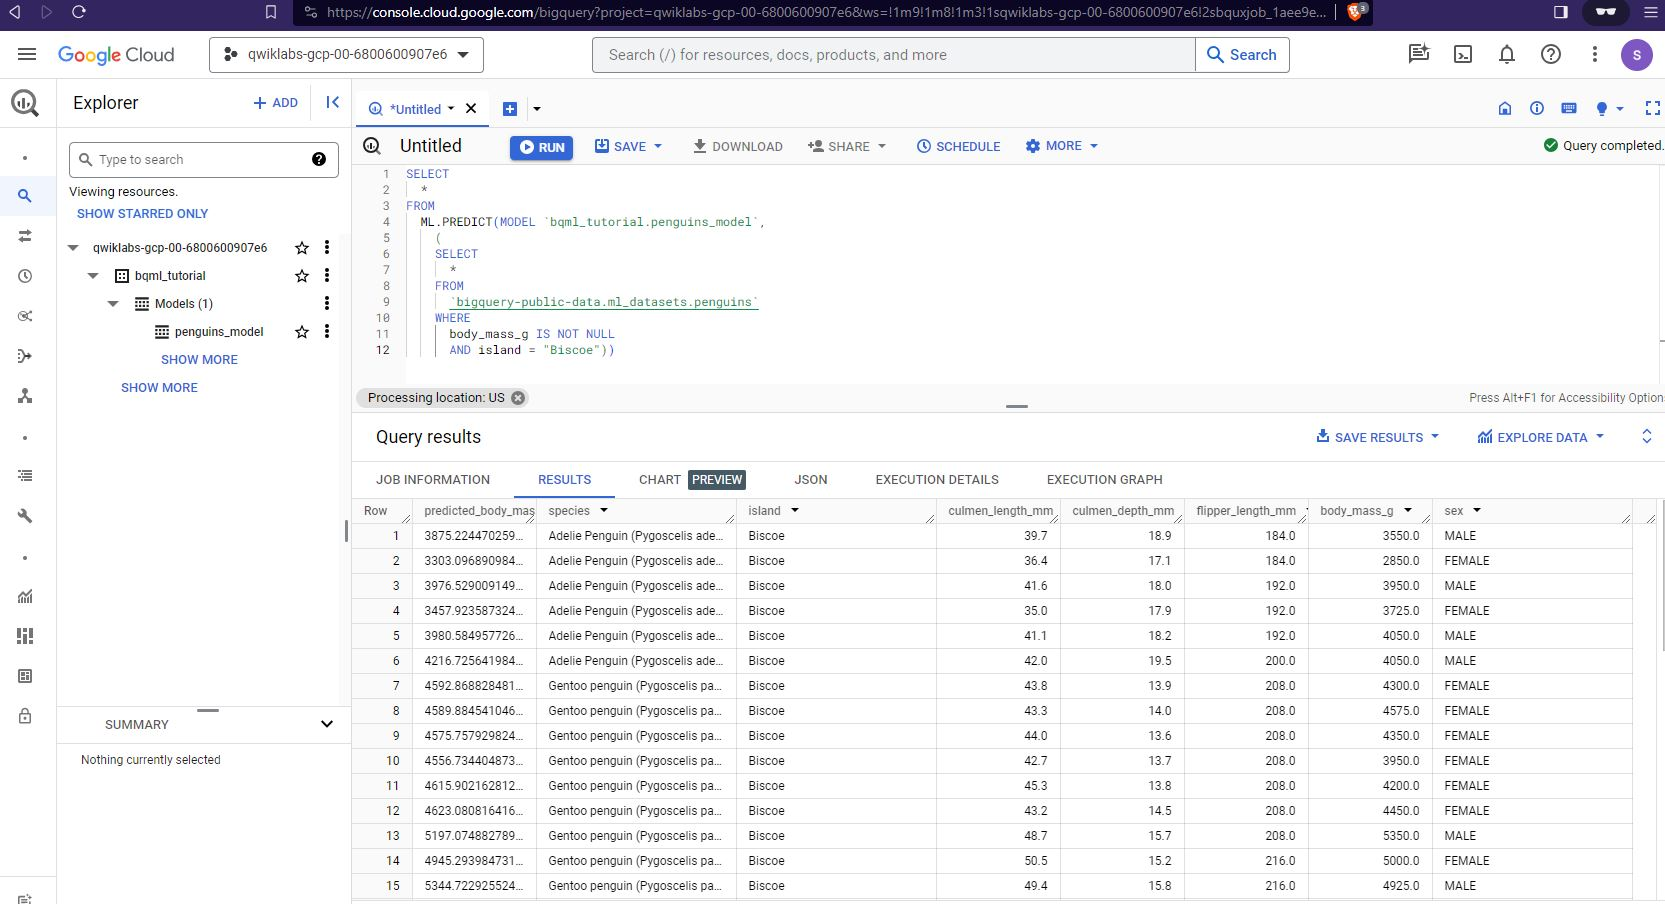

### Task 6. Explain prediction results with explainable AI methods

To understand why your model is generating these prediction results, you can use the [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict) function.

ML.EXPLAIN_PREDICT is an extended version of ML.PREDICT. ML.EXPLAIN_PREDICT returns prediction results with additional columns that explain those results.

You can run ML.EXPLAIN_PREDICT without ML.PREDICT. For an in-depth explanation of Shapley values and explainable AI in BigQuery ML, see [BigQuery ML explainable AI overview](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview#explainable_ai_offerings_in_bigquery_ml).

The following query is used to generate explanations:

In [ ]:
#standardSQL
SELECT
  *
FROM
  ML.EXPLAIN_PREDICT(MODEL `bqml_tutorial.penguins_model`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.ml_datasets.penguins`
    WHERE
      body_mass_g IS NOT NULL
      AND island = "Biscoe"),
    STRUCT(3 as top_k_features))

### Query details
Run the ML.EXPLAIN_PREDICT query

To run the ML.EXPLAIN_PREDICT query that explains the model:

1. In the Cloud Console, click Compose new query.

2. In the Query editor text area, enter the previous standard SQL query.

3. Click Run.

4. When the query is complete, click the Results tab below the query text area. The results should look like the following:

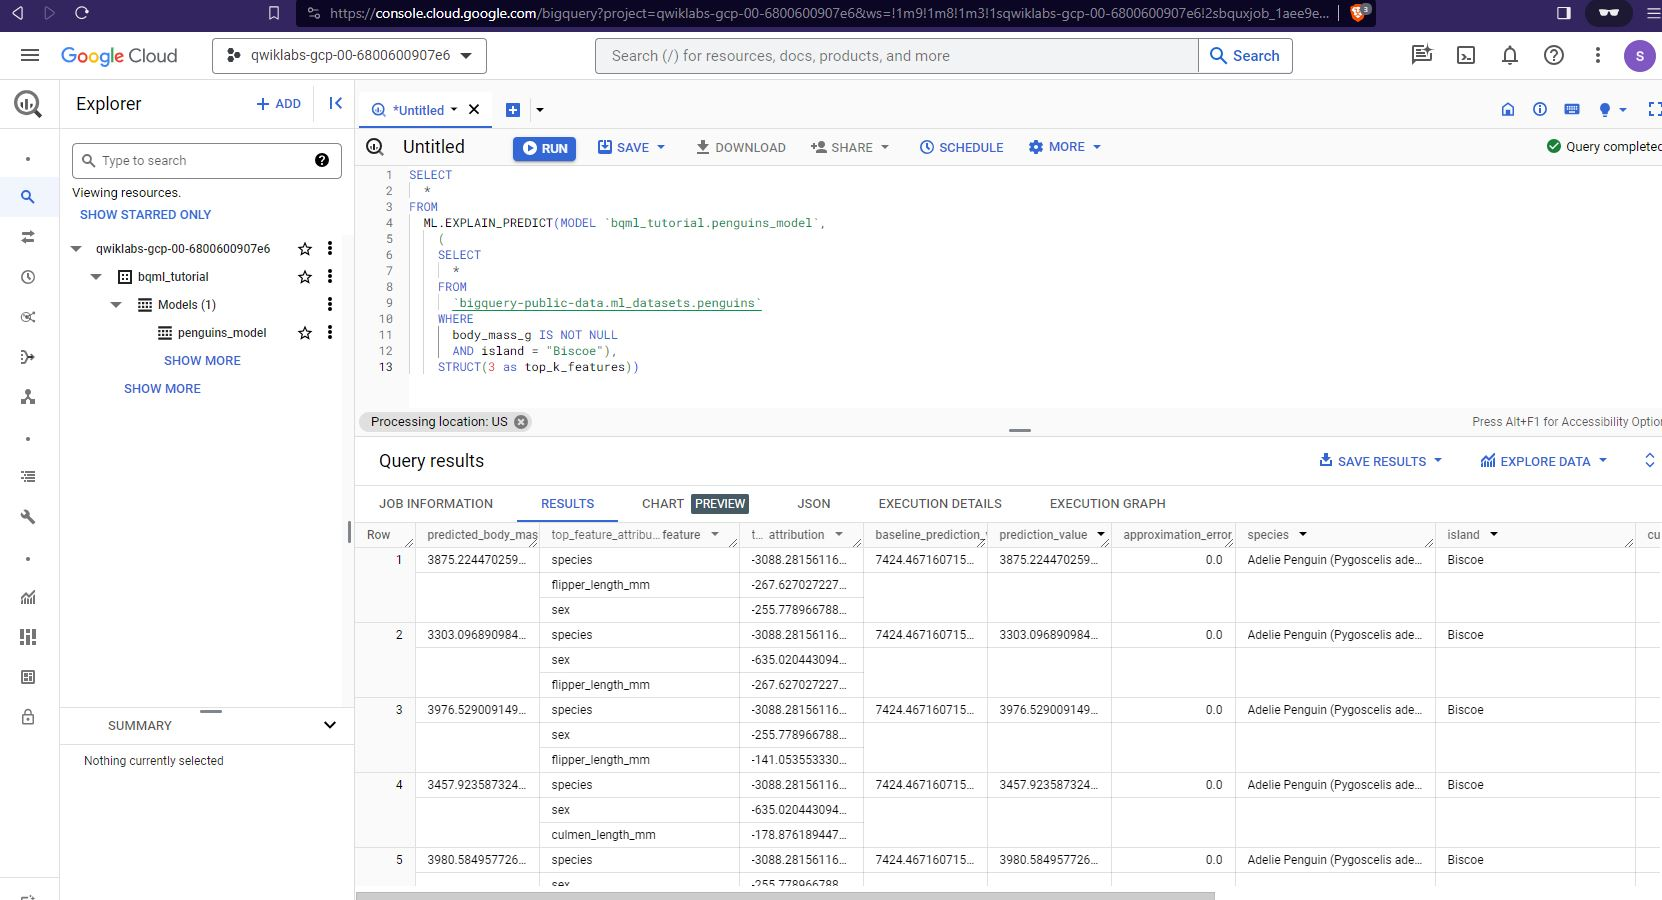

> Note: The ML.EXPLAIN_PREDICT query outputs all the input feature columns, similar to what ML.PREDICT does. Only one feature column, "species", is shown in the figure above for readability purposes.

For linear regression models, Shapley values are used to generate feature attribution values per feature in the model. ML.EXPLAIN_PREDICT outputs the top 3 feature attributions per row of the table provided because top_k_features was set to 3 in the query.

These attributions are sorted by the absolute value of the attribution in descending order. In all examples, the feature sex contributed the most to the overall prediction. For detailed explanations of the output columns of the ML.EXPLAIN_PREDICT query, see [ML.EXPLAIN_PREDICT syntax documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict#mlexplain_predict_output).

### Task 7. Globally explain your model 

To know which features are the most important to determine the weights of the penguins in general, you can use the [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain) function. In order to use ML.GLOBAL_EXPLAIN, the model must be `retrained with the option ENABLE_GLOBAL_EXPLAIN=TRUE`.

Rerun the training query with this option using the following query:

In [ ]:
#standardSQL
CREATE OR REPLACE MODEL bqml_tutorial.penguins_model
OPTIONS
  (model_type='linear_reg',
  input_label_cols=['body_mass_g'],
  enable_global_explain=TRUE) AS
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.penguins`
WHERE
  body_mass_g IS NOT NULL

> Note: You can ignore the warning about NULL values for input data

### Access global explanations through ML.GLOBAL_EXPLAIN
The following query is used to generate global explanations:

In [ ]:
#standardSQL
SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL `bqml_tutorial.penguins_model`)

### Query details
Run the ML.GLOBAL_EXPLAIN query

To run the ML.GLOBAL_EXPLAIN query:

1. In the Cloud Console, click Compose new query.

2. In the Query editor text area, enter the previous standard SQL query.

3. (Optional) To set the data location, click More > Query settings. For Data location, select us (multiple regions in United States).

4. Click Run.

5 When the query is complete, click the Results tab below the query text area. The results should look like the following:

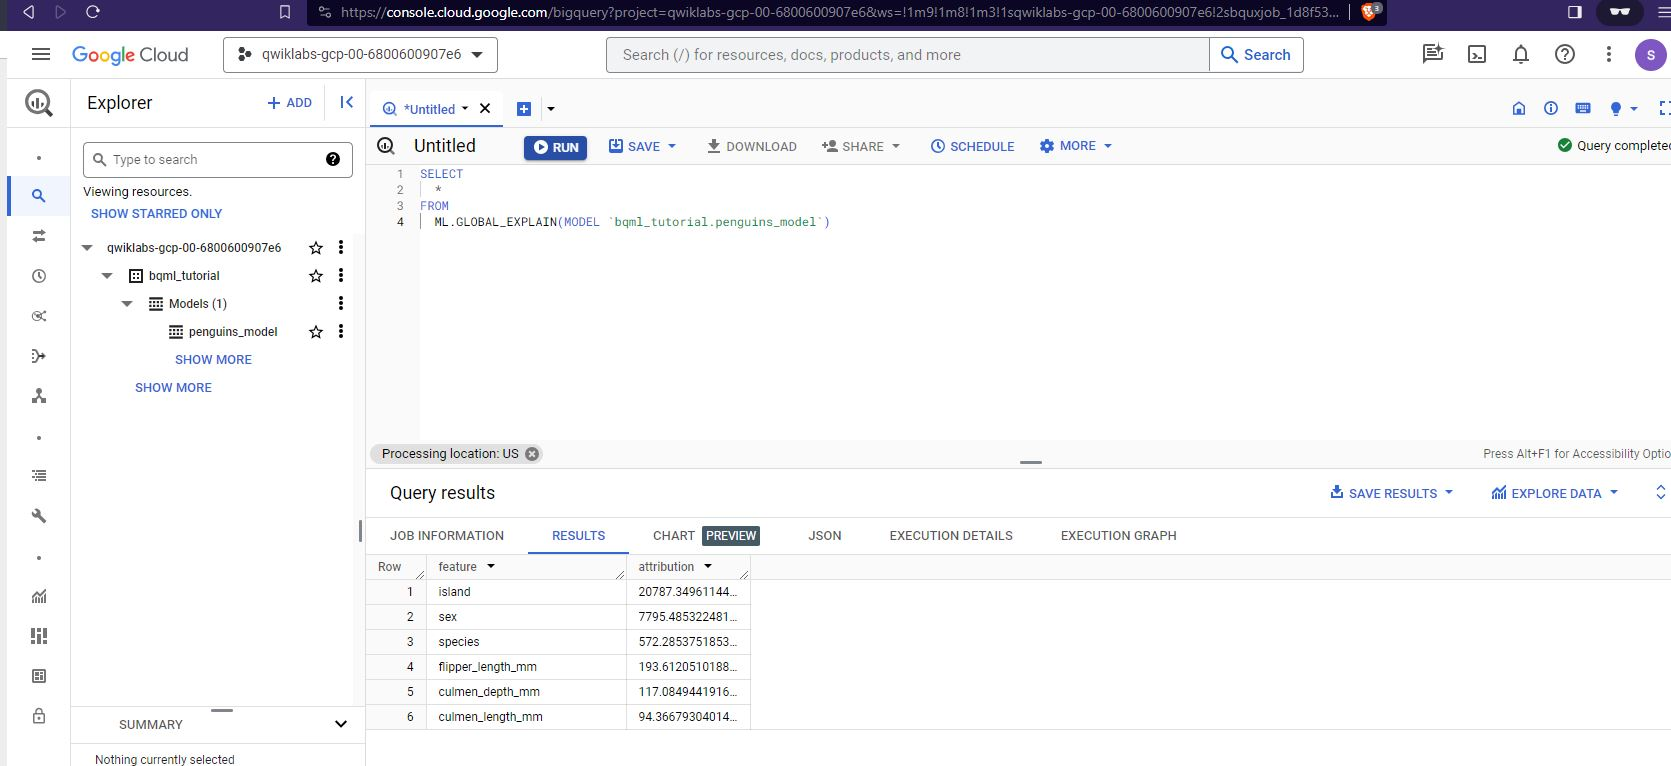

### Task 8. Clean up

To avoid incurring charges to your Google Cloud account for the resources used in this tutorial, either delete the project that contains the resources, or keep the project and delete the individual resources.

### Deleting your dataset
Deleting your project removes all datasets and all tables in the project. If you prefer to reuse the project, you can delete the dataset you created in this tutorial:

1. If necessary, open the BigQuery page in the Cloud Console.

2. In the Explorer panel, click View actions (View actions icon) next to your dataset.

3. Click Delete.

4. In the Delete dataset dialog box, to confirm the delete command, type delete and then click Delete.

### Deleting your project
To delete the project:

1. In the Cloud Console, on the Navigation menu, click IAM & Admin > Manage Resources.
>Note: If prompted, Click LEAVE for unsaved work.

2. In the project list, select the project that you want to delete, and then click Delete.

3. In the dialog, type the project ID, and then click Shut down to delete the project.

#### Key Takeaways

We've learned how to:

- Create a linear regression model using the CREATE MODEL statement with BigQuery ML.
- Evaluate the ML model with the ML.EVALUATE function.
- Make predictions using the ML model with the ML.PREDICT function.